In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import cupy as cp
import pandas as pd
from scipy.optimize import minimize
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
# === Softmax ===
def softmax(W, X):
    logits = X @ W
    logits -= cp.max(logits, axis=1, keepdims=True)
    exp_logits = cp.exp(logits)
    return exp_logits / cp.sum(exp_logits, axis=1, keepdims=True)

# === Matrix square root ===
def real_sqrtm(M):
    from scipy.linalg import sqrtm
    return cp.asarray(sqrtm(cp.asnumpy(M + 1e-6 * cp.eye(M.shape[0]))).real)

In [3]:
# === Scatter matrices ===
def compute_scatter_matrices(X, y):
    n_features = X.shape[1]
    classes = cp.unique(y)
    overall_mean = cp.mean(X, axis=0)
    Sb = cp.zeros((n_features, n_features))
    Sw = cp.zeros((n_features, n_features))
    for c in classes:
        X_c = X[y == c]
        mean_c = cp.mean(X_c, axis=0)
        n_c = X_c.shape[0]
        Sb += n_c * cp.outer(mean_c - overall_mean, mean_c - overall_mean)
        Sw += (X_c - mean_c).T @ (X_c - mean_c)
    return Sb, Sw

In [4]:
# === S2FS ===
def S2FS(X, y, alpha, lambda_, max_iter=500, tol=1e-4, print_interval=50):
    n_samples, n_features = X.shape
    n_classes = len(cp.unique(y))
    Y = cp.eye(n_classes)[y]

    Sb, Sw = compute_scatter_matrices(X, y)
    Sb_sqrt = real_sqrtm(Sb)
    inv_Sb_sqrt = cp.linalg.pinv(Sb_sqrt)

    W = cp.random.randn(n_features, n_classes)
    M = cp.zeros_like(W)
    O = W.copy()
    Lambda1 = cp.zeros_like(W)
    Lambda2 = cp.zeros_like(W)

    mu = 1.0
    rho = 1.1

    for t in range(max_iter):
        A = inv_Sb_sqrt @ (cp.eye(n_features) + (alpha / mu) * Sw) @ inv_Sb_sqrt
        B = inv_Sb_sqrt @ (M + O - (Lambda1 + Lambda2) / mu)
        Q, _ = cp.linalg.qr(cp.random.randn(n_features, n_classes))
        for _ in range(10):
            tau = 1 / (2 * cp.linalg.norm(A, 2))
            T = 2 * (cp.eye(n_features) - tau * A) @ Q + B
            U, _, Vt = cp.linalg.svd(T, full_matrices=False)
            Q = U @ Vt
        W_new = Sb_sqrt @ Q

        # M update
        threshold = cp.sqrt(2 * lambda_ / mu)
        M_temp = W_new - Lambda1 / mu
        row_norms = cp.linalg.norm(M_temp, axis=1)
        M_new = cp.where(row_norms[:, None] > threshold, M_temp, 0)

        # O update using CPU optimizer
        def loss_and_grad(O_vec_np):
            O_mat = cp.asarray(O_vec_np).reshape(n_features, n_classes)
            probs = softmax(O_mat, X)
            loss = -cp.sum(Y * cp.log(probs + 1e-12)) / n_samples
            loss += (mu / 2) * cp.linalg.norm(O_mat - (W_new - Lambda2 / mu))**2
            grad = X.T @ (probs - Y) / n_samples + mu * (O_mat - (W_new - Lambda2 / mu))
            return float(loss), cp.asnumpy(grad.ravel())

        res = minimize(loss_and_grad, cp.asnumpy(O.ravel()), method='L-BFGS-B', jac=True)
        O_new = cp.asarray(res.x).reshape(n_features, n_classes)

        if cp.linalg.norm(W_new - M_new) < tol and cp.linalg.norm(W_new - O_new) < tol:
            print(f"Converged at iteration {t}")
            break

        Lambda1 += mu * (W_new - M_new)
        Lambda2 += mu * (W_new - O_new)
        mu *= rho
        W, M, O = W_new, M_new, O_new

        if (t + 1) % print_interval == 0:
            feature_scores = cp.linalg.norm(W, axis=1)
            selected = feature_scores > cp.sqrt(2 * lambda_ / mu)
            print(f"Iteration {t + 1}: Selected features = {cp.sum(selected)}")

    return W, mu

In [5]:
# === Main (with MNIST) ===
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_np = mnist.data[:3495]
y_np = mnist.target[:3495].astype(int)

# Preprocessing
X_np = StandardScaler().fit_transform(X_np)
y_np = LabelEncoder().fit_transform(y_np)

# Convert to CuPy
X = cp.asarray(X_np)
y = cp.asarray(y_np)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
# Grid search
alpha_list = [10**i for i in range(-6, 3)]
lambda_list = [10**i for i in range(-6, -1)]

best_acc = 0
best_params = None
best_W = None
best_mu = None

for alpha in alpha_list:
    for lambda_ in lambda_list:
        print(f"Training with α={alpha}, λ={lambda_}")
        W, mu_final = S2FS(X_train, y_train, alpha, lambda_, max_iter=500)

        feature_scores = cp.linalg.norm(W, axis=1)
        selected = cp.argsort(feature_scores)[::-1][:int(0.1 * X.shape[1])]
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(cp.asnumpy(X_train[:, selected]), cp.asnumpy(y_train))
        acc = clf.score(cp.asnumpy(X_val[:, selected]), cp.asnumpy(y_val))
        print(f"Validation Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = (alpha, lambda_)
            best_W = W
            best_mu = mu_final

Training with α=1e-06, λ=1e-06
Iteration 50: Selected features = 546
Iteration 100: Selected features = 643
Iteration 150: Selected features = 643
Iteration 200: Selected features = 643
Iteration 250: Selected features = 643
Iteration 300: Selected features = 643
Iteration 350: Selected features = 643
Iteration 400: Selected features = 643
Iteration 450: Selected features = 643
Iteration 500: Selected features = 643
Validation Accuracy: 0.7941
Training with α=1e-06, λ=1e-05
Iteration 50: Selected features = 239
Iteration 100: Selected features = 160
Iteration 150: Selected features = 346
Iteration 200: Selected features = 420
Iteration 250: Selected features = 479
Iteration 300: Selected features = 521
Iteration 350: Selected features = 555
Iteration 400: Selected features = 576
Iteration 450: Selected features = 590
Iteration 500: Selected features = 605
Validation Accuracy: 0.8742
Training with α=1e-06, λ=0.0001
Iteration 50: Selected features = 0
Iteration 100: Selected features = 6

In [7]:
# Final reporting
final_threshold = cp.sqrt(2 * best_params[1] / best_mu)
final_scores = cp.linalg.norm(best_W, axis=1)
selected_features = final_scores > final_threshold
n_selected = cp.sum(selected_features)

print("\nBest Hyperparameters:")
print(f"Alpha = {best_params[0]}, Lambda = {best_params[1]}")
print(f"Best Validation Accuracy: {best_acc:.4f}")
print(f"Number of Selected Features = {n_selected}")


Best Hyperparameters:
Alpha = 1e-06, Lambda = 1e-05
Best Validation Accuracy: 0.8742
Number of Selected Features = 605


In [8]:
# Accuracy vs. Feature Ratio Plot
ratios = cp.linspace(0.02, 0.2, 10)
accuracies = []
feature_counts = []
sorted_indices = cp.argsort(final_scores)[::-1]

for r in ratios:
    k = max(1, int(r * X.shape[1]))
    selected = sorted_indices[:k]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(cp.asnumpy(X_train[:, selected]), cp.asnumpy(y_train))
    acc = clf.score(cp.asnumpy(X_val[:, selected]), cp.asnumpy(y_val))
    accuracies.append(acc)
    feature_counts.append(k)
    print(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

Ratio: 0.02, Features: 15, Accuracy: 0.5777
Ratio: 0.04, Features: 31, Accuracy: 0.7989
Ratio: 0.06, Features: 47, Accuracy: 0.8236
Ratio: 0.08, Features: 62, Accuracy: 0.8475
Ratio: 0.10, Features: 78, Accuracy: 0.8742
Ratio: 0.12, Features: 94, Accuracy: 0.8904
Ratio: 0.14, Features: 109, Accuracy: 0.8980
Ratio: 0.16, Features: 125, Accuracy: 0.8999
Ratio: 0.18, Features: 141, Accuracy: 0.9047
Ratio: 0.20, Features: 156, Accuracy: 0.9142


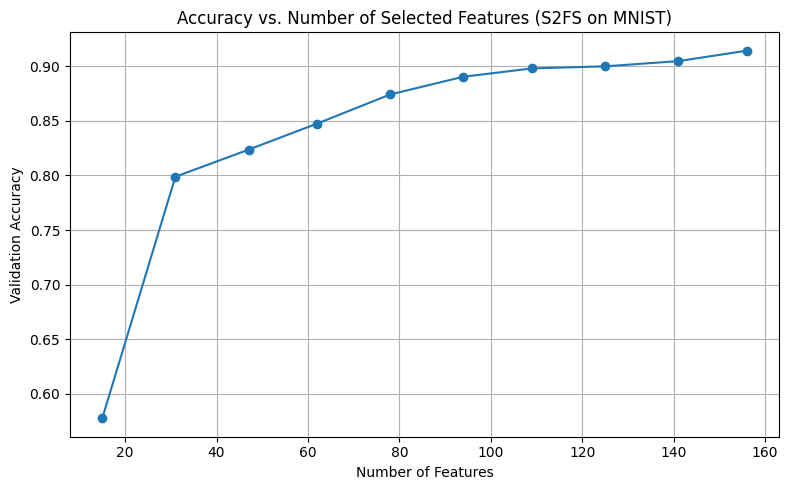

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Accuracy vs. Number of Selected Features (S2FS on MNIST)")
plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()